# Deep Learning: Detecting Facial Expressions

This notebook is the result a semester-long project for my deep learning course (UMSL, CMP SCI 4390, Spring 2021).

Phases:

<ol type="I">
  <li><a href="#phase-1">Data Preparation</a></li>
  <li><a href="#phase-2">Model Overfitting</a></li>
  <li><a href="#phase-3">Model Testing</a></li>
  <li><a href="#phase-4">Effects of Augmentation</a></li>
  <li><a href="#phase-5">Effects of Regularization</a></li>
  <li><a href="#phase-6">Alternative Models and Architectures</a></li>
</ol>

**Goal:** Build a reproducible machine learning model that can detect 5 moods: angry, astonished, happy, neutral, sad.

**Dataset:** 1000 256x256 shuffled grayscale images of my cropped face in different lighting conditions captured using an iPhone 6s. 200 images per mood. Randomly divided into 3 folders: train (600), val (200), and test (200).

**Dataset Source:** https://raw.githubusercontent.com/jaredible/CS4390-Project/master/dataset.zip

**Project Repository:** https://github.com/jaredible/CS4390-Project

In [ ]:
# Import dependencies
import io, os, re, requests, zipfile, math
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.utils import shuffle

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator

from PIL import ImageFont
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
import tensorflow.keras.applications as kapps
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, InceptionV3
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Initialize configurations
MAGIC_NUM = 420
np.random.seed(MAGIC_NUM)
np.set_printoptions(formatter = {'float': '{: 0.1f}'.format})
tf.random.set_seed(MAGIC_NUM)

<a name="phase-1"></a>
## Data Preparation: Phase I

In [ ]:
# Upload dataset
r = requests.get('https://raw.githubusercontent.com/jaredible/CS4390-Project/master/dataset.zip') 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
dataset_path = 'dataset'

train_path = dataset_path + '/train'
val_path = dataset_path + '/val'
test_path = dataset_path + '/test'

num_train_samples = sum([len(files) for _, _, files in os.walk(train_path)])
num_val_samples = sum([len(files) for _, _, files in os.walk(val_path)])
num_test_samples = sum([len(files) for _, _, files in os.walk(test_path)])
total_num_samples = num_train_samples + num_val_samples + num_test_samples

print('# train samples: {}'.format(num_train_samples))
print('# validation samples: {}'.format(num_val_samples))
print('# test samples: {}'.format(num_test_samples))
print('total # samples: {}'.format(total_num_samples))
print('train ratio: {}%'.format(round(num_train_samples / total_num_samples * 100, 2)))
print('validation ratio: {}%'.format(round(num_val_samples / total_num_samples * 100, 2)))
print('test ratio: {}%'.format(round(num_test_samples / total_num_samples * 100, 2)))

# train samples: 600
# validation samples: 200
# test samples: 200
total # samples: 1000
train ratio: 60.0%
validation ratio: 20.0%
test ratio: 20.0%


In [ ]:
IMG_SIZE = (256, 256)

class_names = sorted([x for x in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, x))])
print(class_names)
class_dictionary = {class_name: i for i, class_name in enumerate(class_names)}
print(class_dictionary)

['angry', 'astonish', 'happy', 'neutral', 'sad']
{'angry': 0, 'astonish': 1, 'happy': 2, 'neutral': 3, 'sad': 4}


In [ ]:
def load_data(grayscale = True):
  datasets = [train_path, val_path, test_path]
  output = []

  for dataset in datasets:
    Images = []
    Labels = []

    print("Loading {}".format(dataset))

    for folder in sorted(os.listdir(dataset)):
      curr_label = class_dictionary[folder]
      #print(curr_label)

      for file in sorted(os.listdir(os.path.join(dataset, folder))):
        img_path = os.path.join(os.path.join(dataset, folder), file)
        #print(img_path)

        curr_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_ANYCOLOR)

        Images.append(curr_img)
        Labels.append(curr_label)

    Images = np.array(Images)
    Labels = np.array(Labels)
    output.append((Images, Labels))
  return output

In [ ]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_data()

print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

Loading dataset/train
Loading dataset/val
Loading dataset/test
(600, 256, 256)
(200, 256, 256)
(200, 256, 256)


Found 600 images belonging to 5 classes.


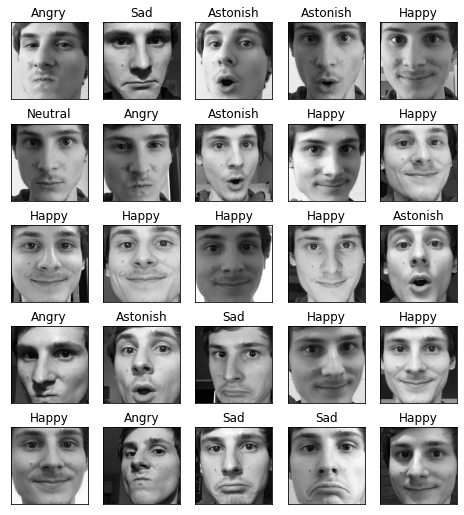

In [ ]:
datagen = ImageDataGenerator(rescale = 1.0 / 255)
generator = datagen.flow_from_directory(train_path,
                                        target_size = IMG_SIZE,
                                        batch_size = 64,
                                        class_mode = 'categorical')

fig = plt.figure(figsize = (8, 9))
rows, columns = 5, 5
ax = []

for batch in generator:
  images = batch[0]
  labels = batch[1]
  for i in range(rows * columns):
    ax.append(fig.add_subplot(rows, columns, i + 1))
    ax[-1].set_title(str.title(list(class_dictionary.keys())[list(class_dictionary.values()).index(np.nonzero(labels[i] == 1)[0][0])]))
    plot = plt.imshow(images[i, :, :, 0], cmap = 'gray')
  break

plt.setp(ax, xticks=[], yticks=[])
plt.show()

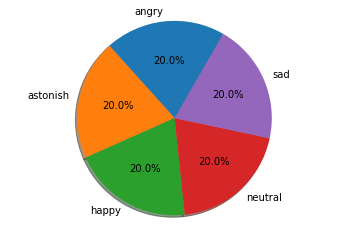

In [ ]:
# Visualize class distribution
sizes = np.bincount(train_labels)
explode = (0, 0, 0, 0, 0)
plt.pie(sizes, explode=explode, labels=class_names, autopct='%1.1f%%', shadow=True, startangle=420)
plt.axis('equal')
plt.show()

### Cleaning

To keep things simple, the dataset has already been cleaned.

Note: iPhone 6s saves images in JPG format and specifies, seemingly pointless, orientation metadata (EXIF), so I rotated them. Explanation: https://stackoverflow.com/a/10601175

### Normalization

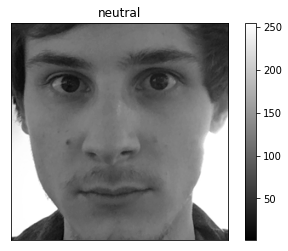

In [ ]:
# Sample before normalization
plt.title(class_names[train_labels[MAGIC_NUM]])
plt.imshow(train_images[MAGIC_NUM], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

In [ ]:
x_train = train_images.reshape((num_train_samples, IMG_SIZE[0], IMG_SIZE[1], 1))
x_val = val_images.reshape((num_val_samples, IMG_SIZE[0], IMG_SIZE[1], 1))
x_test = test_images.reshape((num_test_samples, IMG_SIZE[0], IMG_SIZE[1], 1))

# Rescale pixels
train_imgs = x_train / 255.0
val_imgs = x_val / 255.0
test_imgs = x_test / 255.0

y_train = tf.keras.utils.to_categorical(train_labels)
y_val = tf.keras.utils.to_categorical(val_labels)
y_test = tf.keras.utils.to_categorical(test_labels)

print(x_train.shape)
print(y_train.shape)
print(y_train[0])

(600, 256, 256, 1)
(600, 5)
[ 1.0  0.0  0.0  0.0  0.0]


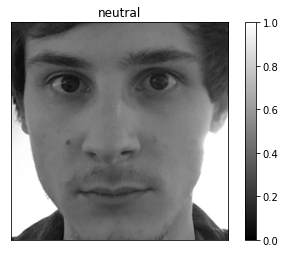

In [ ]:
# Sample after normalization
plt.title(class_names[train_labels[MAGIC_NUM]])
plt.imshow(train_imgs[MAGIC_NUM, :, :, 0], cmap='gray', vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

<a name="phase-2"></a>
## Model Overfitting: Phase II

In [ ]:
all_images = np.concatenate((train_images, val_images, test_images), axis=0)
print(all_images.shape)
all_labels = np.concatenate((train_labels, val_labels, test_labels), axis=0)
print(all_labels.shape)

x_all_train = all_images.reshape((total_num_samples, IMG_SIZE[0], IMG_SIZE[1], 1))
all_images = all_images / 255.0
y_all_train = tf.keras.utils.to_categorical(all_labels)

print(x_all_train.shape)
print(y_all_train.shape)
print(y_all_train[0])

(1000, 256, 256)
(1000,)
(1000, 256, 256, 1)
(1000, 5)
[ 1.0  0.0  0.0  0.0  0.0]


In [ ]:
NUM_EPOCHS = 25
NUM_BATCHES = 64

In [ ]:
def summarize_model(model):
  model.summary()

In [ ]:
def train_model(model, x_train, y_train, epochs=NUM_EPOCHS, batches=NUM_BATCHES):
  return model.fit(x_train, y_train, epochs=epochs, batch_size=batches)

In [ ]:
def show_learning_curves(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['acc'])
  ax1.set(xlabel='Epoch', ylabel='Accuracy')
  ax1.legend(['All Data'], loc='lower right')
  ax2.plot(history.history['loss'])
  ax2.set(xlabel='Epoch', ylabel='Loss')
  ax2.legend(['All Data'], loc='upper right')
  fig.show()

In [ ]:
def show_statistics(model, x_train, labels):
  prediction = np.argmax(model.predict(x_train), axis=1)
  accuracy = accuracy_score(labels, prediction) * 100
  precision = precision_score(labels, prediction, average='micro') * 100
  recall = recall_score(labels, prediction, average='micro') * 100
  f1 = f1_score(labels, prediction, average='micro') * 100
  print("Accuracy: %.2f%%, Precision: %.2f%%, Recall: %.2f%%, F1: %.2f%%" % (accuracy, precision, recall, f1))
  return prediction

In [ ]:
def show_confusion_matrix(class_names, labels, prediction):
  cm = confusion_matrix(labels, prediction)
  plt.figure(figsize=(9, 7))
  sns.heatmap(cm, annot=True, annot_kws={'size': 15}, xticklabels=class_names, yticklabels=class_names, fmt='g')
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()

In [ ]:
def show_mislabeled_images(class_names, true_images, true_labels, pred_labels):
  true_images = true_images.reshape((true_images.shape[0], IMG_SIZE[0], IMG_SIZE[1]))
  mislabeled_index = np.where((true_labels == pred_labels) == 0)
  mislabeled_images = true_images[mislabeled_index]
  mislabeled_labels = pred_labels[mislabeled_index]

  fig = plt.figure(figsize = (10, 10))

  for i in range(len(mislabeled_images)):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mislabeled_images[i], cmap=plt.cm.gray)
    plt.xlabel(class_names[mislabeled_labels[i]])
  
  plt.show()

#### Baseline Model

Model: "model_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 5)              

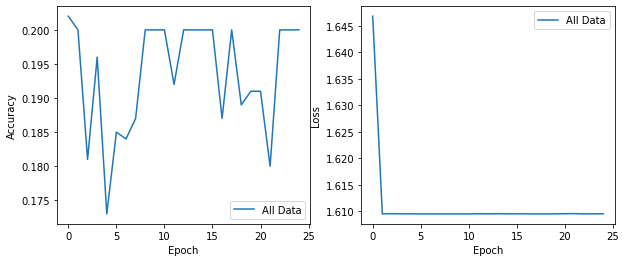

In [ ]:
K.clear_session()
modelBaseline = Sequential(name='model_baseline')
modelBaseline.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_all_train[0, :, :, :].shape))
modelBaseline.add(MaxPool2D(4, 4))
modelBaseline.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
modelBaseline.add(MaxPool2D(4, 4))
modelBaseline.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
modelBaseline.add(Flatten())
modelBaseline.add(Dense(5, activation='relu'))
modelBaseline.add(Dense(5, activation='softmax'))
summarize_model(modelBaseline)
modelBaseline.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
historyBaseline = train_model(modelBaseline, x_all_train, y_all_train)
show_learning_curves(historyBaseline)
predictionBaseline = show_statistics(modelBaseline, x_all_train, all_labels)

#### Overfit Model

Model: "model_overfit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)       

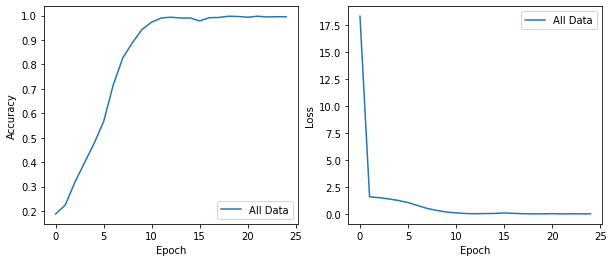

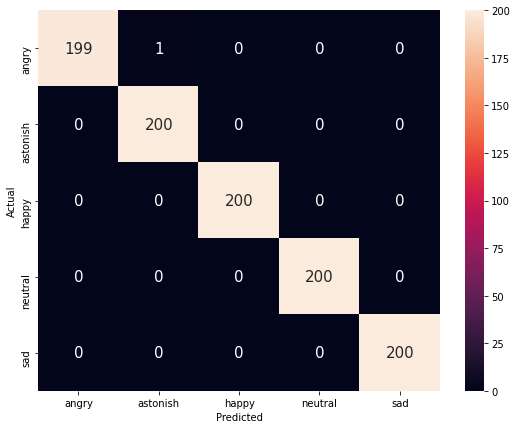

In [ ]:
K.clear_session()
modelOverfit = Sequential(name='model_overfit')
modelOverfit.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_all_train[0, :, :, :].shape))
modelOverfit.add(MaxPool2D(2, 2))
modelOverfit.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
modelOverfit.add(MaxPool2D(2, 2))
modelOverfit.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
modelOverfit.add(MaxPool2D(2, 2))
modelOverfit.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
modelOverfit.add(Flatten())
modelOverfit.add(Dense(128, activation='relu'))
modelOverfit.add(Dense(5, activation='softmax'))
summarize_model(modelOverfit)
modelOverfit.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
historyOverfit = train_model(modelOverfit, x_all_train, y_all_train)
show_learning_curves(historyOverfit)
predictionOverfit = show_statistics(modelOverfit, x_all_train, all_labels)
show_confusion_matrix(class_names, all_labels, predictionOverfit)

#### Overfit Model (Output as Input)

In [ ]:
N = len(x_all_train[:, 0, 0, 0])
W = len(x_all_train[0, :, 0, 0])
H = len(x_all_train[0, 0, :, 0])
x_all_train_with_output = np.zeros((N, W, H, 2))
for i in range(len(x_all_train)):
  existing = x_all_train[i, :, :, :]
  newchannel = np.full((W, H), all_labels[i]).reshape(W, H, 1)
  x = np.concatenate((existing, newchannel), axis=-1)
  x_all_train_with_output[i] = x

Model: "model_special"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 5)       95        
_________________________________________________________________
flatten (Flatten)            (None, 327680)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1638405   
Total params: 1,638,500
Trainable params: 1,638,500
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
16/16 [==============================] - 2s 69ms/step - loss: 10919.4513 - acc: 0.2075
Epoch 2/25
16/16 [==============================] - 1s 52ms/step - loss: 4095.1800 - acc: 0.2540
Epoch 3/25
16/16 [==============================] - 1s 51ms/step - loss: 860.3715 - acc: 0.2725
Epoch 4/25
16/16 [==============================] - 1s 50ms/step - loss: 826.6841 

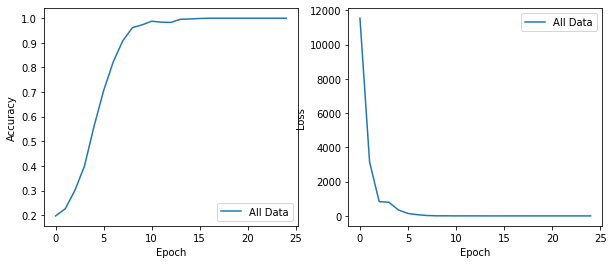

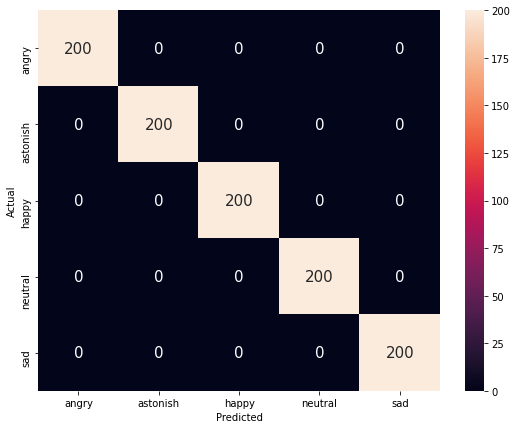

In [ ]:
K.clear_session()
modelSpecial = Sequential(name='model_special')
modelSpecial.add(Conv2D(5, (3, 3), activation='relu', padding='same', input_shape=x_all_train_with_output[0, :, :, :].shape))
modelSpecial.add(Flatten())
modelSpecial.add(Dense(5, activation='softmax'))
modelSpecial.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
summarize_model(modelSpecial)
historySpecial = train_model(modelSpecial, x_all_train_with_output, y_all_train)
show_learning_curves(historySpecial)
predictionSpecial = show_statistics(modelSpecial, x_all_train_with_output, all_labels)
show_confusion_matrix(class_names, all_labels, predictionSpecial)

<a name="phase-3"></a>
## Model Testing: Phase III

In [ ]:
# Clone previous best model
model = keras.models.clone_model(modelOverfit)
model.summary()

# Prepare model for training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Configure callbacks for training
callbacks = []
callbacks.append(ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1))
callbacks.append(EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1))

# Train model
history = model.fit(train_imgs, y_train, validation_data=(val_imgs, y_val), epochs=100, batch_size=64, callbacks=callbacks)

Model: "model_overfit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)       

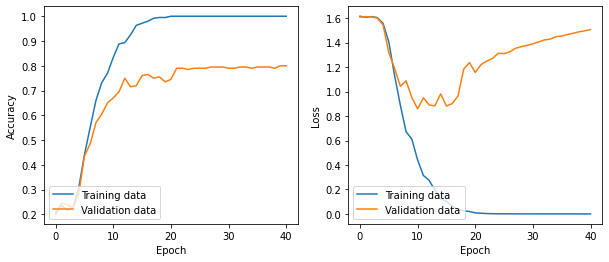

In [ ]:
# Plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['Training data', 'Validation data'], loc='lower left')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['Training data', 'Validation data'], loc='lower left')
fig.show()

7/7 [==============================] - 0s 25ms/step - loss: 1.0803 - acc: 0.8050
Accuracy:  80.50%
Precision: 80.50%
Recall:    80.50%
F1:        80.50%


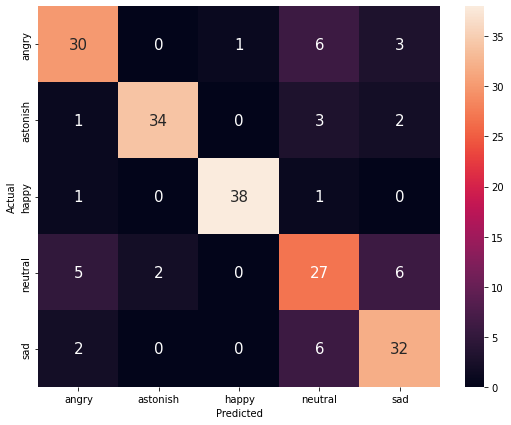

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_imgs, y_test)
prediction = np.argmax(model.predict(test_imgs), axis=1)

# Show performance scores
accuracy = accuracy_score(test_labels, prediction) * 100.0
precision = precision_score(test_labels, prediction, average='micro', zero_division = 0) * 100.0
recall = recall_score(test_labels, prediction, average='micro', zero_division = 0) * 100.0
f1 = f1_score(test_labels, prediction, average='micro', zero_division = 0) * 100.0
print(f"Accuracy:  {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall:    {recall:.2f}%")
print(f"F1:        {f1:.2f}%")

# Show classifiction table
cm = confusion_matrix(test_labels, prediction)
plt.figure(figsize=(9, 7))
g = sns.heatmap(cm, annot=True, annot_kws={'size': 15}, xticklabels=class_names, yticklabels=class_names, fmt='g')
g.set_yticklabels(labels=g.get_yticklabels(), va='center')
g.set_xlabel("Predicted")
g.set_ylabel("Actual")
plt.show()

<a name="phase-4"></a>
## Effects of Augmentation: Phase IV

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   brightness_range = [0.8, 1.2],
                                   shear_range = 0.2,
                                   horizontal_flip = True,
                                   zoom_range = 0.1,
                                   fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale = 1.0 / 255)

test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size = IMG_SIZE,
                                                    color_mode = 'grayscale',
                                                    batch_size = 64,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

val_generator = val_datagen.flow_from_directory(val_path,
                                                target_size = IMG_SIZE,
                                                color_mode = 'grayscale',
                                                batch_size = 64,
                                                class_mode = 'categorical',
                                                shuffle = True)
 
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size = IMG_SIZE,
                                                  color_mode='grayscale',
                                                  batch_size = 64,
                                                  class_mode='categorical')

Found 600 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


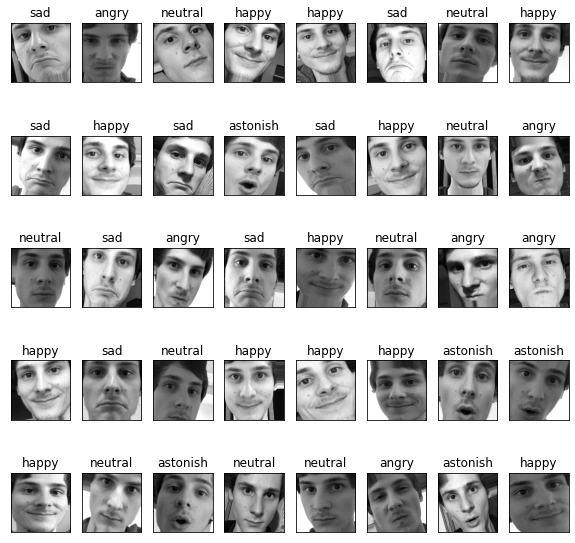

In [ ]:
fig = plt.figure(figsize = (10, 10))
rows, columns = 5, 8
ax = []

for batch in train_generator:
  images = batch[0]
  labels = batch[1]
  for i in range(rows * columns):
    ax.append(fig.add_subplot(rows, columns, i + 1))
    ax[-1].set_title(list(class_dictionary.keys())[list(class_dictionary.values()).index(np.nonzero(labels[i] == 1)[0][0])])
    plot = plt.imshow(images[i, :, :, 0], cmap = 'gray')
  break

plt.setp(ax, xticks = [], yticks = [])
plt.show()

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same', input_shape = train_imgs[0, :, :, :].shape))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(8, (3, 3), activation = 'relu', padding = 'same'))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         1

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

callbacks = []
callbacks.append(ModelCheckpoint(filepath = 'model.h5', monitor = 'val_loss', save_best_only = True, save_weights_only = True, verbose = 1))
callbacks.append(EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 100, verbose = 1))

history = model.fit(train_generator,
                    epochs = 10000,
                    callbacks = callbacks,
                    validation_data = val_generator)

Epoch 1/10000
10/10 [==============================] - 6s 515ms/step - loss: 1.6170 - acc: 0.2089 - val_loss: 1.6096 - val_acc: 0.2000

Epoch 00001: val_loss improved from inf to 1.60961, saving model to model.h5
Epoch 2/10000
10/10 [==============================] - 5s 478ms/step - loss: 1.6122 - acc: 0.2016 - val_loss: 1.6094 - val_acc: 0.2100

Epoch 00002: val_loss improved from 1.60961 to 1.60937, saving model to model.h5
Epoch 3/10000
10/10 [==============================] - 5s 510ms/step - loss: 1.6094 - acc: 0.1743 - val_loss: 1.6092 - val_acc: 0.2250

Epoch 00003: val_loss improved from 1.60937 to 1.60923, saving model to model.h5
Epoch 4/10000
10/10 [==============================] - 5s 474ms/step - loss: 1.6091 - acc: 0.2051 - val_loss: 1.6076 - val_acc: 0.2050

Epoch 00004: val_loss improved from 1.60923 to 1.60764, saving model to model.h5
Epoch 5/10000
10/10 [==============================] - 5s 477ms/step - loss: 1.6052 - acc: 0.2521 - val_loss: 1.5970 - val_acc: 0.2500



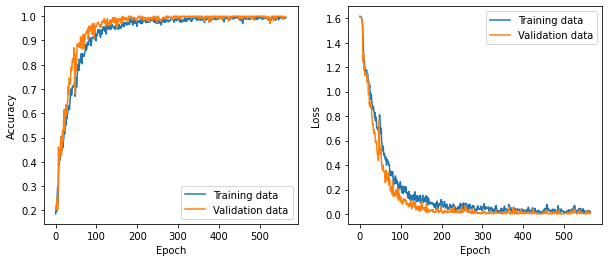

In [ ]:
# Plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax1.legend(['Training data', 'Validation data'], loc = 'lower right')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set(xlabel = 'Epoch', ylabel = 'Loss')
ax2.legend(['Training data', 'Validation data'], loc = 'upper right')
fig.show()

7/7 [==============================] - 0s 26ms/step - loss: 0.0082 - acc: 1.0000
Accuracy:  100.00%
Precision: 100.00%
Recall:    100.00%
F1:        100.00%


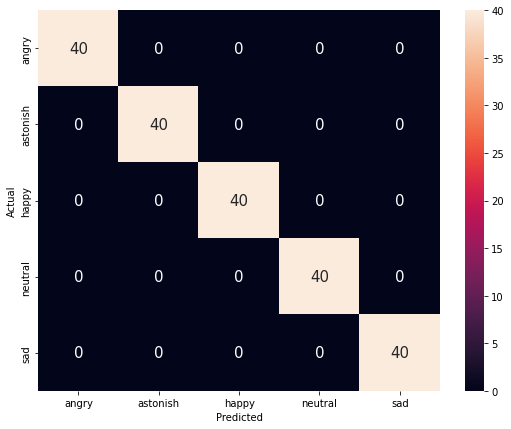

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_imgs, y_test)
prediction = np.argmax(model.predict(test_imgs), axis = 1)

# Show performance scores
accuracy = accuracy_score(test_labels, prediction) * 100.0
precision = precision_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
recall = recall_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
f1 = f1_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
print(f"Accuracy:  {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall:    {recall:.2f}%")
print(f"F1:        {f1:.2f}%")

# Show classifiction table
cm = confusion_matrix(test_labels, prediction)
plt.figure(figsize = (9, 7))
g = sns.heatmap(cm, annot = True, annot_kws = {'size': 15}, xticklabels = class_names, yticklabels = class_names, fmt = 'g')
g.set_yticklabels(labels = g.get_yticklabels(), va = 'center')
g.set_xlabel("Predicted")
g.set_ylabel("Actual")
plt.show()

In [ ]:
# Show misclassified images
pred_labels = np.argmax(model.predict(test_imgs), axis = 1)
compare = (test_labels == pred_labels)
mislabeled_indices = np.where(compare == 0)
mislabeled_images = test_images[mislabeled_indices]
mislabeled_labels = pred_labels[mislabeled_indices]
fig = plt.figure(figsize = (10, 10))
for i in range(len(mislabeled_indices[0])):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(mislabeled_images[i], cmap = 'gray')
  plt.xlabel(class_names[mislabeled_labels[i]])
plt.show()

<Figure size 720x720 with 0 Axes>

<a name="phase-5"></a>
## Effects of Regularization: Phase V

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = 'relu', activity_regularizer = regularizers.l2(0.01), padding = 'same', input_shape = train_imgs[0, :, :, :].shape))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(8, (3, 3), activation = 'relu', padding = 'same'))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         1

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

callbacks = []
callbacks.append(ModelCheckpoint(filepath = 'model.h5', monitor = 'val_loss', save_best_only = True, save_weights_only = True, verbose = 1))
callbacks.append(EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 30, verbose = 1))

history = model.fit(train_generator,
                    epochs = 1000,
                    callbacks = callbacks,
                    validation_data = val_generator)

Epoch 1/1000
10/10 [==============================] - 6s 509ms/step - loss: 210.3638 - acc: 0.2120 - val_loss: 97.8423 - val_acc: 0.2050

Epoch 00001: val_loss improved from inf to 97.84229, saving model to model.h5
Epoch 2/1000
10/10 [==============================] - 5s 516ms/step - loss: 80.7082 - acc: 0.1952 - val_loss: 36.8483 - val_acc: 0.2000

Epoch 00002: val_loss improved from 97.84229 to 36.84829, saving model to model.h5
Epoch 3/1000
10/10 [==============================] - 5s 524ms/step - loss: 30.4761 - acc: 0.2082 - val_loss: 13.6078 - val_acc: 0.2600

Epoch 00003: val_loss improved from 36.84829 to 13.60782, saving model to model.h5
Epoch 4/1000
10/10 [==============================] - 5s 516ms/step - loss: 11.3589 - acc: 0.2651 - val_loss: 5.3497 - val_acc: 0.3000

Epoch 00004: val_loss improved from 13.60782 to 5.34973, saving model to model.h5
Epoch 5/1000
10/10 [==============================] - 5s 475ms/step - loss: 4.7361 - acc: 0.2418 - val_loss: 2.6384 - val_acc:

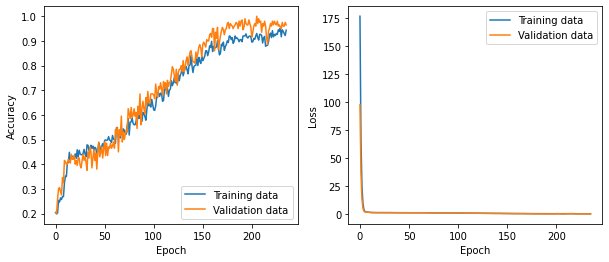

In [ ]:
# Plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax1.legend(['Training data', 'Validation data'], loc = 'lower right')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set(xlabel = 'Epoch', ylabel = 'Loss')
ax2.legend(['Training data', 'Validation data'], loc = 'upper right')
fig.show()

7/7 [==============================] - 0s 15ms/step - loss: 0.2095 - acc: 0.9150
Accuracy:  91.50%
Precision: 91.50%
Recall:    91.50%
F1:        91.50%


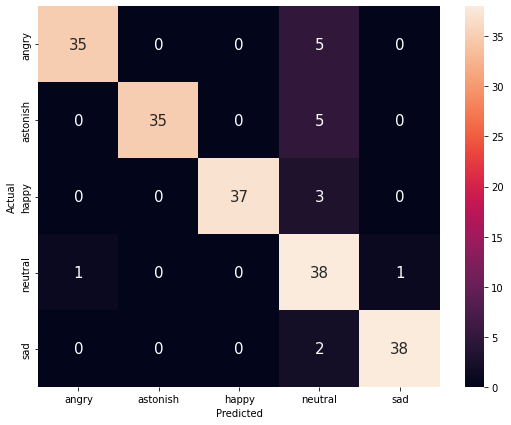

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_imgs, y_test)
prediction = np.argmax(model.predict(test_imgs), axis = 1)

# Show performance scores
accuracy = accuracy_score(test_labels, prediction) * 100.0
precision = precision_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
recall = recall_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
f1 = f1_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
print(f"Accuracy:  {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall:    {recall:.2f}%")
print(f"F1:        {f1:.2f}%")

# Show classifiction table
cm = confusion_matrix(test_labels, prediction)
plt.figure(figsize = (9, 7))
g = sns.heatmap(cm, annot = True, annot_kws = {'size': 15}, xticklabels = class_names, yticklabels = class_names, fmt = 'g')
g.set_yticklabels(labels = g.get_yticklabels(), va = 'center')
g.set_xlabel("Predicted")
g.set_ylabel("Actual")
plt.show()

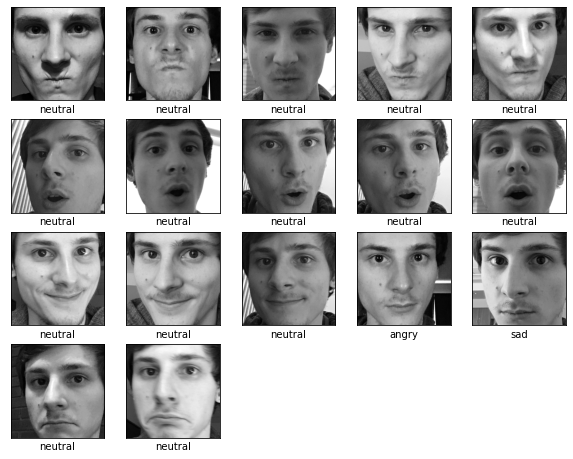

In [ ]:
# Show misclassified images
pred_labels = np.argmax(model.predict(test_imgs), axis = 1)
compare = (test_labels == pred_labels)
mislabeled_indices = np.where(compare == 0)
mislabeled_images = test_images[mislabeled_indices]
mislabeled_labels = pred_labels[mislabeled_indices]
fig = plt.figure(figsize = (10, 10))
for i in range(len(mislabeled_indices[0])):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(mislabeled_images[i], cmap = 'gray')
  plt.xlabel(class_names[mislabeled_labels[i]])
plt.show()

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same', input_shape = train_imgs[0, :, :, :].shape))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(8, (3, 3), activation = 'relu', padding = 'same'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         1

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

callbacks = []
callbacks.append(ModelCheckpoint(filepath = 'model.h5', monitor = 'val_loss', save_best_only = True, save_weights_only = True, verbose = 1))
callbacks.append(EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 30, verbose = 1))

history = model.fit(train_generator,
                    epochs = 1000,
                    callbacks = callbacks,
                    validation_data = val_generator)

Epoch 1/1000
10/10 [==============================] - 5s 492ms/step - loss: 1.6141 - acc: 0.1977 - val_loss: 1.6107 - val_acc: 0.2000

Epoch 00001: val_loss improved from inf to 1.61068, saving model to model.h5
Epoch 2/1000
10/10 [==============================] - 5s 466ms/step - loss: 1.6103 - acc: 0.2007 - val_loss: 1.6079 - val_acc: 0.2250

Epoch 00002: val_loss improved from 1.61068 to 1.60788, saving model to model.h5
Epoch 3/1000
10/10 [==============================] - 5s 467ms/step - loss: 1.6089 - acc: 0.2379 - val_loss: 1.6043 - val_acc: 0.3400

Epoch 00003: val_loss improved from 1.60788 to 1.60426, saving model to model.h5
Epoch 4/1000
10/10 [==============================] - 5s 475ms/step - loss: 1.6007 - acc: 0.3174 - val_loss: 1.5919 - val_acc: 0.3200

Epoch 00004: val_loss improved from 1.60426 to 1.59194, saving model to model.h5
Epoch 5/1000
10/10 [==============================] - 5s 464ms/step - loss: 1.5816 - acc: 0.2742 - val_loss: 1.5128 - val_acc: 0.3550

Epoch

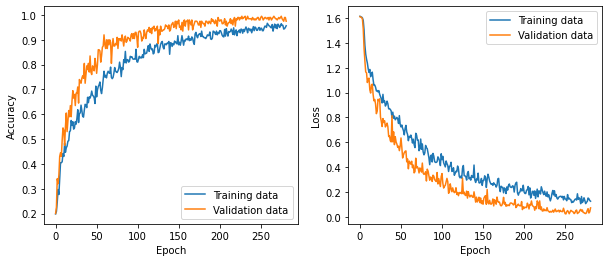

In [ ]:
# Plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax1.legend(['Training data', 'Validation data'], loc = 'lower right')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set(xlabel = 'Epoch', ylabel = 'Loss')
ax2.legend(['Training data', 'Validation data'], loc = 'upper right')
fig.show()

7/7 [==============================] - 0s 12ms/step - loss: 0.1094 - acc: 0.9850
Accuracy:  98.50%
Precision: 98.50%
Recall:    98.50%
F1:        98.50%


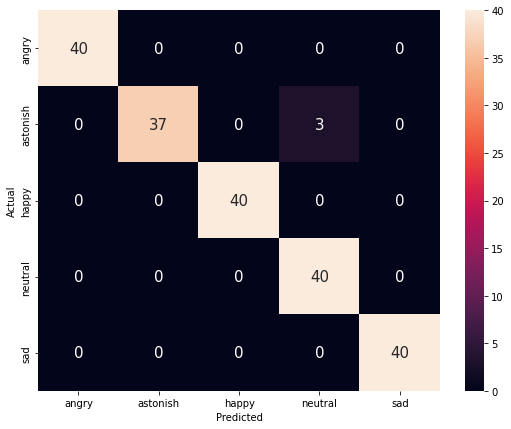

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_imgs, y_test)
prediction = np.argmax(model.predict(test_imgs), axis = 1)

# Show performance scores
accuracy = accuracy_score(test_labels, prediction) * 100.0
precision = precision_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
recall = recall_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
f1 = f1_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
print(f"Accuracy:  {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall:    {recall:.2f}%")
print(f"F1:        {f1:.2f}%")

# Show classifiction table
cm = confusion_matrix(test_labels, prediction)
plt.figure(figsize = (9, 7))
g = sns.heatmap(cm, annot = True, annot_kws = {'size': 15}, xticklabels = class_names, yticklabels = class_names, fmt = 'g')
g.set_yticklabels(labels = g.get_yticklabels(), va = 'center')
g.set_xlabel("Predicted")
g.set_ylabel("Actual")
plt.show()

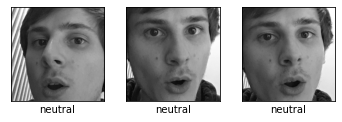

In [ ]:
# Show misclassified images
pred_labels = np.argmax(model.predict(test_imgs), axis = 1)
compare = (test_labels == pred_labels)
mislabeled_indices = np.where(compare == 0)
mislabeled_images = test_images[mislabeled_indices]
mislabeled_labels = pred_labels[mislabeled_indices]
fig = plt.figure(figsize = (10, 10))
for i in range(len(mislabeled_indices[0])):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(mislabeled_images[i], cmap = 'gray')
  plt.xlabel(class_names[mislabeled_labels[i]])
plt.show()

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same', input_shape = train_imgs[0, :, :, :].shape))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(8, (3, 3), activation = 'relu', padding = 'same'))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

callbacks = []
callbacks.append(ModelCheckpoint(filepath = 'model.h5', monitor = 'val_loss', save_best_only = True, save_weights_only = True, verbose = 1))
callbacks.append(EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 30, verbose = 1))

history = model.fit(train_generator,
                    epochs = 1000,
                    callbacks = callbacks,
                    validation_data = val_generator)

Epoch 1/1000
10/10 [==============================] - 6s 530ms/step - loss: 2.1379 - acc: 0.1921 - val_loss: 1.6096 - val_acc: 0.2000

Epoch 00001: val_loss improved from inf to 1.60959, saving model to model.h5
Epoch 2/1000
10/10 [==============================] - 5s 462ms/step - loss: 1.6082 - acc: 0.2205 - val_loss: 1.6090 - val_acc: 0.2100

Epoch 00002: val_loss improved from 1.60959 to 1.60903, saving model to model.h5
Epoch 3/1000
10/10 [==============================] - 5s 458ms/step - loss: 1.6038 - acc: 0.2372 - val_loss: 1.6080 - val_acc: 0.2050

Epoch 00003: val_loss improved from 1.60903 to 1.60799, saving model to model.h5
Epoch 4/1000
10/10 [==============================] - 5s 467ms/step - loss: 1.5704 - acc: 0.2950 - val_loss: 1.5983 - val_acc: 0.2450

Epoch 00004: val_loss improved from 1.60799 to 1.59828, saving model to model.h5
Epoch 5/1000
10/10 [==============================] - 5s 472ms/step - loss: 1.4774 - acc: 0.3454 - val_loss: 1.5979 - val_acc: 0.1900

Epoch

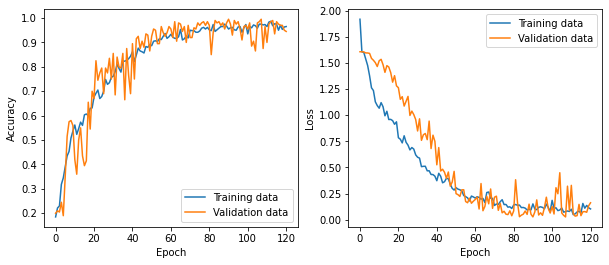

In [ ]:
# Plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax1.legend(['Training data', 'Validation data'], loc = 'lower right')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set(xlabel = 'Epoch', ylabel = 'Loss')
ax2.legend(['Training data', 'Validation data'], loc = 'upper right')
fig.show()

7/7 [==============================] - 0s 14ms/step - loss: 0.1420 - acc: 0.9500
Accuracy:  95.00%
Precision: 95.00%
Recall:    95.00%
F1:        95.00%


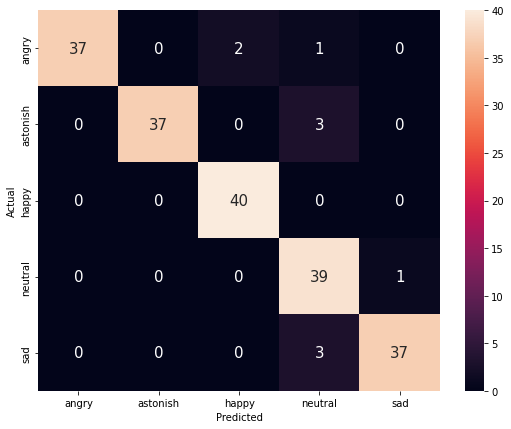

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_imgs, y_test)
prediction = np.argmax(model.predict(test_imgs), axis = 1)

# Show performance scores
accuracy = accuracy_score(test_labels, prediction) * 100.0
precision = precision_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
recall = recall_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
f1 = f1_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
print(f"Accuracy:  {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall:    {recall:.2f}%")
print(f"F1:        {f1:.2f}%")

# Show classifiction table
cm = confusion_matrix(test_labels, prediction)
plt.figure(figsize = (9, 7))
g = sns.heatmap(cm, annot = True, annot_kws = {'size': 15}, xticklabels = class_names, yticklabels = class_names, fmt = 'g')
g.set_yticklabels(labels = g.get_yticklabels(), va = 'center')
g.set_xlabel("Predicted")
g.set_ylabel("Actual")
plt.show()

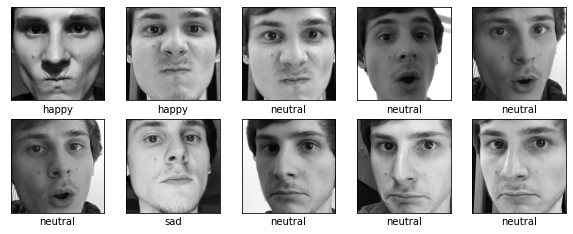

In [ ]:
# Show misclassified images
pred_labels = np.argmax(model.predict(test_imgs), axis = 1)
compare = (test_labels == pred_labels)
mislabeled_indices = np.where(compare == 0)
mislabeled_images = test_images[mislabeled_indices]
mislabeled_labels = pred_labels[mislabeled_indices]
fig = plt.figure(figsize = (10, 10))
for i in range(len(mislabeled_indices[0])):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(mislabeled_images[i], cmap = 'gray')
  plt.xlabel(class_names[mislabeled_labels[i]])
plt.show()

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = 'relu', activity_regularizer = regularizers.l2(0.01), padding = 'same', input_shape = train_imgs[0, :, :, :].shape))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(8, (3, 3), activation = 'relu', padding = 'same'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

callbacks = []
callbacks.append(ModelCheckpoint(filepath = 'model.h5', monitor = 'val_loss', save_best_only = True, save_weights_only = True, verbose = 1))
callbacks.append(EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 30, verbose = 1))

history = model.fit(train_generator,
                    epochs = 1000,
                    callbacks = callbacks,
                    validation_data = val_generator)

Epoch 1/1000
10/10 [==============================] - 6s 502ms/step - loss: 124.1426 - acc: 0.2314 - val_loss: 50.7986 - val_acc: 0.2000

Epoch 00001: val_loss improved from inf to 50.79859, saving model to model.h5
Epoch 2/1000
10/10 [==============================] - 5s 465ms/step - loss: 43.6891 - acc: 0.1649 - val_loss: 17.8053 - val_acc: 0.2000

Epoch 00002: val_loss improved from 50.79859 to 17.80531, saving model to model.h5
Epoch 3/1000
10/10 [==============================] - 5s 471ms/step - loss: 15.1435 - acc: 0.2350 - val_loss: 5.6068 - val_acc: 0.1750

Epoch 00003: val_loss improved from 17.80531 to 5.60678, saving model to model.h5
Epoch 4/1000
10/10 [==============================] - 5s 476ms/step - loss: 4.8318 - acc: 0.1992 - val_loss: 2.2876 - val_acc: 0.2000

Epoch 00004: val_loss improved from 5.60678 to 2.28759, saving model to model.h5
Epoch 5/1000
10/10 [==============================] - 5s 482ms/step - loss: 2.1871 - acc: 0.2125 - val_loss: 1.7591 - val_acc: 0.2

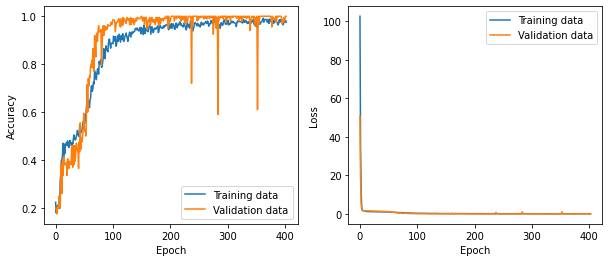

In [ ]:
# Plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax1.legend(['Training data', 'Validation data'], loc = 'lower right')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set(xlabel = 'Epoch', ylabel = 'Loss')
ax2.legend(['Training data', 'Validation data'], loc = 'upper right')
fig.show()

7/7 [==============================] - 0s 16ms/step - loss: 0.0236 - acc: 0.9950
Accuracy:  99.50%
Precision: 99.50%
Recall:    99.50%
F1:        99.50%


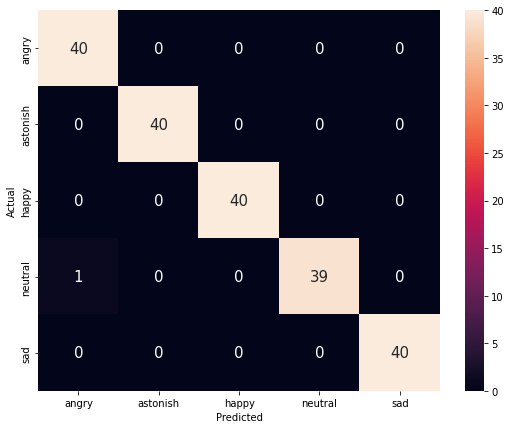

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_imgs, y_test)
prediction = np.argmax(model.predict(test_imgs), axis = 1)

# Show performance scores
accuracy = accuracy_score(test_labels, prediction) * 100.0
precision = precision_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
recall = recall_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
f1 = f1_score(test_labels, prediction, average = 'micro', zero_division = 0) * 100.0
print(f"Accuracy:  {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall:    {recall:.2f}%")
print(f"F1:        {f1:.2f}%")

# Show classifiction table
cm = confusion_matrix(test_labels, prediction)
plt.figure(figsize = (9, 7))
g = sns.heatmap(cm, annot = True, annot_kws = {'size': 15}, xticklabels = class_names, yticklabels = class_names, fmt = 'g')
g.set_yticklabels(labels = g.get_yticklabels(), va = 'center')
g.set_xlabel("Predicted")
g.set_ylabel("Actual")
plt.show()

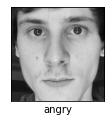

In [ ]:
# Show misclassified images
pred_labels = np.argmax(model.predict(test_imgs), axis = 1)
compare = (test_labels == pred_labels)
mislabeled_indices = np.where(compare == 0)
mislabeled_images = test_images[mislabeled_indices]
mislabeled_labels = pred_labels[mislabeled_indices]
fig = plt.figure(figsize = (10, 10))
for i in range(len(mislabeled_indices[0])):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(mislabeled_images[i], cmap = 'gray')
  plt.xlabel(class_names[mislabeled_labels[i]])
plt.show()

<a name="phase-6"></a>
## Alternative Models and Architectures: Phase VI

In [ ]:
NUM_EPOCHS = 1000
NUM_BATCHES = 64

In [ ]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_data(grayscale = False)

print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

Loading dataset/train
Loading dataset/val
Loading dataset/test
(600, 256, 256, 3)
(200, 256, 256, 3)
(200, 256, 256, 3)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   brightness_range = [0.8, 1.2],
                                   shear_range = 0.2,
                                   horizontal_flip = True,
                                   zoom_range = 0.1,
                                   fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale = 1.0 / 255)

test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size = IMG_SIZE,
                                                    batch_size = NUM_BATCHES,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

val_generator = val_datagen.flow_from_directory(val_path,
                                                target_size = IMG_SIZE,
                                                batch_size = NUM_BATCHES,
                                                class_mode = 'categorical',
                                                shuffle = True)
 
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size = IMG_SIZE,
                                                  batch_size = NUM_BATCHES,
                                                  class_mode='categorical')

Found 600 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


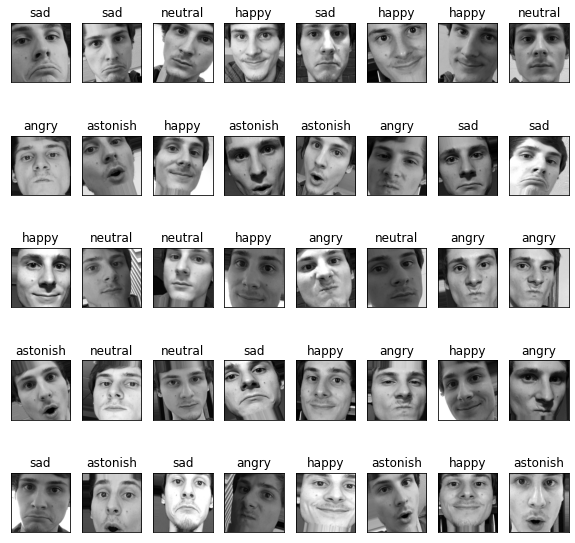

In [ ]:
fig = plt.figure(figsize = (10, 10))
rows, columns = 5, 8
ax = []

for batch in train_generator:
  images = batch[0]
  labels = batch[1]
  for i in range(rows * columns):
    ax.append(fig.add_subplot(rows, columns, i + 1))
    ax[-1].set_title(list(class_dictionary.keys())[list(class_dictionary.values()).index(np.nonzero(labels[i] == 1)[0][0])])
    plot = plt.imshow(images[i, :, :], cmap = 'gray')
  break

plt.setp(ax, xticks = [], yticks = [])
plt.show()

In [ ]:
model_archs = ['VGG16', 'ResNet50', 'DenseNet121', 'InceptionV3']
histories = {}
evaluations = {}

for model_arch in model_archs:
  model_base = getattr(kapps, model_arch)(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))
  for layer in model_base.layers:
    layer.trainable = False
  K.clear_session()
  model = Sequential(name = model_arch)
  model.add(model_base)
  model.add(Flatten())
  model.add(Dense(128, activation = 'relu'))
  model.add(Dense(5, activation = 'softmax'))
  model.summary()

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

  callbacks = []
  callbacks.append(ModelCheckpoint(filepath = f'model_{model.name}.h5', monitor = 'val_loss', save_best_only = True, save_weights_only = True, verbose = 1))
  callbacks.append(EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 30, verbose = 1))

  history = model.fit(train_generator,
                      epochs = NUM_EPOCHS,
                      callbacks = callbacks,
                      validation_data = val_generator)

  histories[model_arch] = history
  evaluations[model_arch] = model.evaluate(test_images, y_test)

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4194432   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 18,909,765
Trainable params: 4,195,077
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 13s 1s/step - loss: 8.0374 - acc: 0.2105 - val_loss: 2.1026 - val_acc: 0.2400

Epoch 00001: val_loss improved from inf to 2.10260, saving model to model_VGG16.h5
Epoch 2/1000
10/10 [===

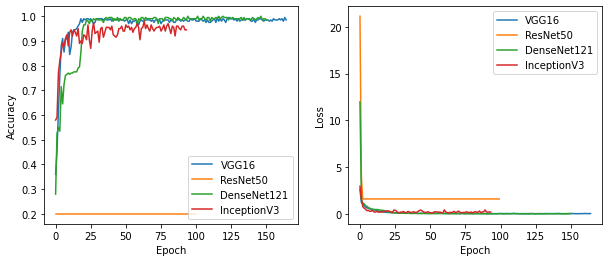

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
for model_arch in model_archs:
  #ax1.plot(histories[model_arch].history['acc'])
  ax1.plot(histories[model_arch].history['val_acc'])
ax1.set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax1.legend(model_archs, loc = 'lower right')
for model_arch in model_archs:
  #ax2.plot(histories[model_arch].history['loss'])
  ax2.plot(histories[model_arch].history['val_loss'])
ax2.set(xlabel = 'Epoch', ylabel = 'Loss')
ax2.legend(model_archs, loc = 'upper right')
fig.show()